In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('churn.csv')
 
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
 
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
 
df.churn = (df.churn == 'yes').astype(int)

In [3]:
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,male,0,yes,yes,24,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,yes,mailed_check,84.80,1990.50,0
7039,2234-xaduh,female,0,yes,yes,72,yes,yes,fiber_optic,no,...,yes,no,yes,yes,one_year,yes,credit_card_(automatic),103.20,7362.90,0
7040,4801-jzazl,female,0,yes,yes,11,no,no_phone_service,dsl,yes,...,no,no,no,no,month-to-month,yes,electronic_check,29.60,346.45,0
7041,8361-ltmkd,male,1,yes,no,4,yes,yes,fiber_optic,no,...,no,no,no,no,month-to-month,yes,mailed_check,74.40,306.60,1


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
 
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents','phoneservice', 'multiplelines', 'internetservice','onlinesecurity', 'onlinebackup',
               'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling','paymentmethod']

In [6]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [8]:
len(y_val)

1409

In [9]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [10]:
scores= []

for t in thresholds:
    churn_decision = y_pred >= t
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


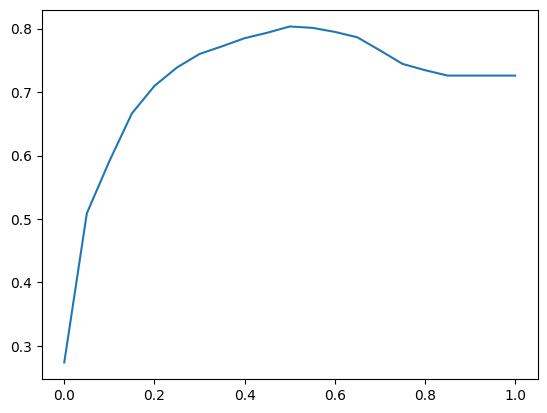

In [11]:
plt.plot(thresholds, scores)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >=0.5)

0.8034066713981547

In [14]:
actual_positive = y_val == 1
actual_negative = y_val == 0 

In [15]:
threshold = 0.5
predicted_positive = y_pred >= threshold
predicted_negative = y_pred < threshold

In [16]:
TP = (actual_positive & predicted_positive).sum()
TN = (actual_negative & predicted_negative).sum()

In [17]:
TP, TN

(np.int64(210), np.int64(922))

In [18]:
FP = (actual_negative & predicted_positive).sum()
FN = (actual_positive & predicted_negative).sum()

In [19]:
FP, FN

(np.int64(101), np.int64(176))

In [20]:
precision = TP / (TP + FP)
precision

np.float64(0.6752411575562701)

In [21]:
recall = TP / (TP + FN)
recall

np.float64(0.5440414507772021)

In [22]:
TPR = TP/ (TP + FN)
TPR

np.float64(0.5440414507772021)

In [23]:
FPR = FP/ (TN + FP)
FPR

np.float64(0.09872922776148582)

In [24]:
scores= []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0) 
    
    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)

    TP = (actual_positive & predicted_positive).sum()
    TN = (actual_negative & predicted_negative).sum()
    FP = (actual_negative & predicted_positive).sum()
    FN = (actual_positive & predicted_negative).sum()

    scores.append((t, TP, TN, FP, FN))

scores[::10]

[(np.float64(0.0), np.int64(386), np.int64(0), np.int64(1023), np.int64(0)),
 (np.float64(0.1), np.int64(366), np.int64(467), np.int64(556), np.int64(20)),
 (np.float64(0.2), np.int64(333), np.int64(667), np.int64(356), np.int64(53)),
 (np.float64(0.3), np.int64(284), np.int64(787), np.int64(236), np.int64(102)),
 (np.float64(0.4), np.int64(249), np.int64(857), np.int64(166), np.int64(137)),
 (np.float64(0.5), np.int64(210), np.int64(922), np.int64(101), np.int64(176)),
 (np.float64(0.6), np.int64(150), np.int64(970), np.int64(53), np.int64(236)),
 (np.float64(0.7000000000000001),
  np.int64(76),
  np.int64(1003),
  np.int64(20),
  np.int64(310)),
 (np.float64(0.8), np.int64(13), np.int64(1022), np.int64(1), np.int64(373)),
 (np.float64(0.9), np.int64(0), np.int64(1023), np.int64(0), np.int64(386)),
 (np.float64(1.0), np.int64(0), np.int64(1023), np.int64(0), np.int64(386))]

In [25]:
columns = ['threshold', "TP", "TN", "FP", "FN"]
df_scores = pd.DataFrame(scores, columns= columns)
df_scores[::10]

,threshold,TP,TN,FP,FN
0,0.0,386,0,1023,0
10,0.1,366,467,556,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,210,922,101,176
60,0.6,150,970,53,236
70,0.7,76,1003,20,310
80,0.8,13,1022,1,373
90,0.9,0,1023,0,386


In [26]:
df_scores["TPR"] = df_scores.TP/ (df_scores.TP + df_scores.FN)
df_scores["FPR"] = df_scores.FP/ (df_scores.TN + df_scores.FP)

In [27]:
df_scores[::10]

,threshold,TP,TN,FP,FN,TPR,FPR
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,150,970,53,236,0.388601,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


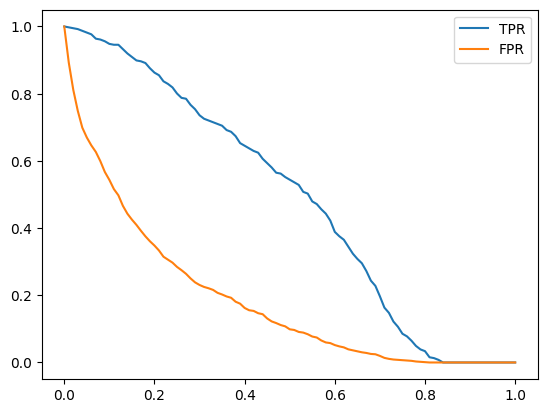

In [28]:
plt.plot(df_scores.threshold, df_scores.TPR, label = "TPR")
plt.plot(df_scores.threshold, df_scores.FPR, label = "FPR")
plt.legend()

In [29]:
from sklearn.metrics import roc_curve

In [30]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

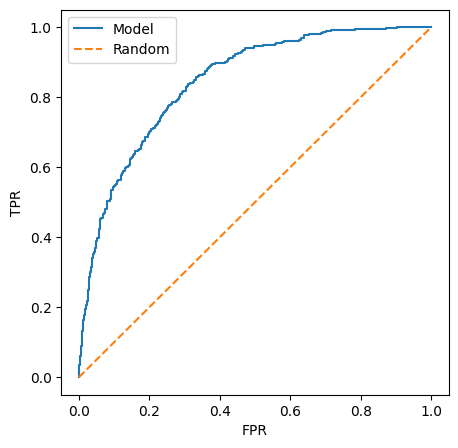

In [31]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label ="Model")
plt.plot([0, 1], [0, 1], label = "Random", linestyle = "--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

Using sklearn for ROC curve

In [32]:
from sklearn.metrics import roc_curve

In [33]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)

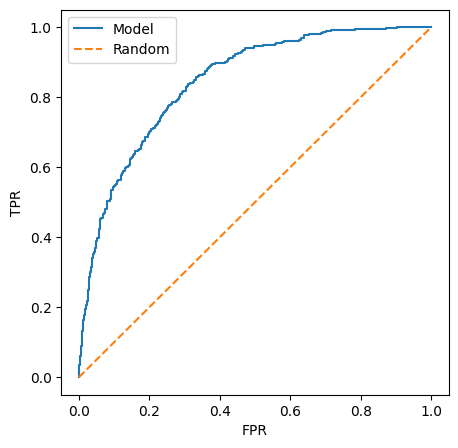

In [34]:
plt.figure(figsize = (5,5))

plt.plot(fpr, tpr, label = "Model")
plt.plot([0, 1], [0, 1], label = "Random", linestyle = "--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

To find the area under the ROC curve. AUC takes in FPR as x and TPR as y.

In [35]:
from sklearn.metrics import auc

In [36]:
auc(fpr, tpr)

np.float64(0.8438201165929731)

Using roc_auc_score, we can find AUC directly from y_true and y_pred.

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

np.float64(0.8438201165929731)

KFOLD CROSS VALIDATION

In [38]:
from sklearn.model_selection import KFold

In [40]:
kfold = KFold(n_splits= 10, shuffle= True, random_state= 1)
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x7cd8a28febd0>

In [41]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [43]:
len(train_idx), len(val_idx)

(5070, 564)

In [44]:
df_train = df_full_train.iloc[train_idx]
df_train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
611,4765-oxppd,female,0,yes,yes,9,yes,no,dsl,yes,...,yes,yes,no,no,month-to-month,no,mailed_check,65.00,663.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2250-ivbwa,male,0,yes,yes,64,yes,no,fiber_optic,yes,...,no,no,no,no,month-to-month,no,electronic_check,81.05,5135.35,0
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [45]:
df_val = df_full_train.iloc[val_idx]
df_val

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0
6672,2346-czyil,male,0,no,no,27,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,credit_card_(automatic),20.35,531.60,0
6203,1090-pykci,female,0,yes,yes,69,yes,yes,fiber_optic,yes,...,yes,yes,yes,no,one_year,yes,credit_card_(automatic),105.10,7234.80,0
1374,8999-ypybv,male,0,yes,yes,45,yes,no,dsl,yes,...,yes,yes,yes,yes,two_year,yes,mailed_check,84.35,3858.05,0
4902,5092-stpkp,female,0,no,no,24,yes,no,dsl,yes,...,no,yes,no,no,month-to-month,no,credit_card_(automatic),56.35,1381.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6121,7337-cinud,female,0,yes,yes,8,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,bank_transfer_(automatic),19.50,159.35,0
562,3701-sfmuh,male,0,yes,yes,7,yes,no,dsl,yes,...,no,no,yes,yes,month-to-month,no,credit_card_(automatic),69.70,516.15,0
2962,3237-ajgeh,female,0,yes,yes,3,no,no_phone_service,dsl,no,...,no,yes,no,no,month-to-month,yes,mailed_check,31.00,95.05,1
5056,3262-eidhv,female,0,yes,yes,72,yes,yes,dsl,yes,...,yes,yes,yes,yes,two_year,no,credit_card_(automatic),84.70,5893.90,0
